In [1]:
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path, save_one_box
from utils.plots import colors, plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

In [2]:
#读取012标签
import pandas
import pandas as pd
excel_path=r"打分比例表-并列2013 -汇总分表４.２８－票库(1).xlsx"
data = pandas.read_excel(excel_path,engine='openpyxl')
data=data[['图像名称','齿孔']]
data=data.dropna()
def dele(df):
    df=df[:-3]
    df.replace('(','（')
    df.replace(')','）')
    if '.GT'in df:
        df=df[:-3]
    return df
data['图像名称']=data['图像名称'].apply(dele)
data['图像名称'].astype('str')

data=data.rename({'图像名称':'名称'},axis=1)
data=data.dropna()

def caonima(df):
    if df['名称'][-3:]!='（2）':
        df['名称']=df['名称']+"（2）"
    return df
data1=data.copy().apply(caonima,axis=1)


def fuck(df):
    if df[-3:]=='（2）':
        print(df)
#data['名称'].apply(fuck)

data2=pd.concat([data,data1])

#最终标签data2

In [3]:
data

,名称,齿孔
1,2013-1,0
2,2013-10M,1
3,2013-11,1
4,2013-12.8-1,2
5,2013-12.8-2,2
...,...,...
2602,烈士像.1,1
2603,航空.1,1
2604,航空.2,1
2605,航空.3,1


In [4]:
import os
#path="/media/mtc206/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp37/labels/"
#path="/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp37/labels/"
path="/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp53/labels/"
a=set()
for i in os.listdir(path):
    a.add(i[:-5])
#print(a)
import re
d=[]
for i in a:
    b=[]
    for j in os.listdir(path):
        c=[]
        if(j[-4:]!='.txt'):
            continue
        if(i==j[:-5]):
            txt_name = j[:-4] + ".txt"
            # save_path = r".\stamp_myhandle", save_stamp_info_path = r"stamp_info_txt"
            txt_path = os.path.join(path, txt_name)
            with open(txt_path, "r", encoding='gbk') as fr:
                for line in fr.readlines():
                    line = line.strip()
                    line_list = line.split(" ")
                    xml_w = float(line_list[-2])
                    xml_h = float(line_list[-1])
                    xml_length=max(xml_w,xml_h)
                    xml_area=xml_w*xml_h
                    c=[xml_length,xml_area]
                    b.append(c)
    d.append(b)
zip(list(a),d)

k={}
for i in range(a.__len__()):
    k[list(a)[i]]=d[i]
for i in os.listdir("/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp53/"):
    if i[-3:]!='jpg':
        
        #print(2)
        continue
    if i[:-5] not in list(k.keys()):
        k.update({i[:-5]:[]})
        #print(1)
list_length=[]
list_area=[]
list_number=[]
for i in k:
    max_length=0
    area=0
    n=0
    for j in k[i]:
        max_length=max(max_length,j[0])
        area+=j[1]
        n+=1
    list_length.append(max_length)
    list_area.append(area)
    list_number.append(n)
    
df=pd.DataFrame()
df['名称']=list(k.keys())
df['最大长']=list_length
df['面积']=list_area
df['个数']=list_number


In [5]:
df

,名称,最大长,面积,个数
0,2219_2019-29.6-5,0.844616,0.321480,1
1,2367_J93.6-2,0.360000,0.049169,7
2,711_2010-16(4-4)7,0.739024,0.936178,10
3,489_╞╒╬▐║┼╠ь░▓├┼-93,0.370620,0.145865,15
4,468_╞╒╬▐║┼╠ь░▓├┼-72,0.315283,0.061317,4
...,...,...,...,...
1981,258_T108.6-4A,0.000000,0.000000,0
1982,2254_J21.6-2,0.000000,0.000000,0
1983,27_2013-17.4-2,0.000000,0.000000,0
1984,1109_J19(4-4)10,0.000000,0.000000,0


In [16]:
def chuli(df1):
    if '_' in df1:
        df1=df1.split('_')[1]
    return df1
df['名称']=df['名称'].apply(chuli)
    

In [17]:
#合并
ans=pd.merge(data2,df,how='right')
ans=ans.dropna()
ans=ans.rename({'名称':'name','齿孔':'chikong','最大长':'zuidachang','面积':'area','个数':'number'},axis=1)
ans=ans.dropna()

In [18]:
ans=ans[ans['number']!=0]

In [19]:
ans

,name,chikong,zuidachang,area,number
0,2013-17.4-1,2,0.792204,0.539684,11
1,2013-14.6-6,2,0.334619,0.020999,3
2,纪93.2-1.4,2,0.459054,0.093775,6
3,2013-特8,2,0.325859,0.047608,4
4,纪8.3-1,2,0.841040,1.786658,18
5,纪8.3-1.1,2,0.883204,1.757982,17
6,纪7东.2-1,2,0.793736,0.682127,15
7,纪7东.2-1.2,2,0.774265,1.438439,16
8,2013-30.4-1,1,0.287879,0.032804,4
9,2013-2.3-3,2,0.451532,0.462728,13


In [11]:
train

,name,chikong,zuidachang,area,number
0,2019-29.6-5,2.0,0.844616,0.321480,1
1,J93.6-2,1.0,0.360000,0.049169,7
7,T21-5-3,1.0,0.256845,0.030646,4
10,J105.5-2.1,2.0,0.374140,0.095678,10
11,T135(3-1)3,1.0,0.335221,0.049505,4
...,...,...,...,...,...
1976,1998-2.4-1,2.0,0.366126,0.097934,8
1979,T17.6-5,1.0,0.340992,0.049663,4
1980,T148.4-1.1,2.0,0.378254,0.170191,15
1983,T135(3-3)4,2.0,0.408519,0.143168,4


In [12]:
#模型训练
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import math
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
import joblib

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error ,accuracy_score

numerical_cols =ans.select_dtypes(exclude = 'object').columns

ans['chikong']=ans['chikong'].astype(float)
#train=ans[:int(0.9*len(ans))]
train=ans
test=ans[int(0.9*len(ans)):]
feature_cols = [col for col in numerical_cols if col not in ['label']]
feature_cols = [col for col in feature_cols if 'chikong' not in col]
#feature_cols = [col for col in feature_cols if 'area' not in col]

## 提前特征列，标签列构造训练样本和测试样本
X_data = train[feature_cols]
Y_data = train['chikong']
X_test  = test[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)


def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))
    
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)
base='/2TB/wjn/yolov5/beifen/yolov5/2/'
score_perf_model_path1=base+'score_perf_1.model'
score_perf_model_path2=base+'score_perf_2.model'
score_perf_model_path3=base+'score_perf_3.model'
def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(n_estimators = 150)
    param_grid = {
        'num_leaves':[20,50,127,150,200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

def build_model_lgb_c(x_train,y_train):
    estimator = lgb.LGBMClassifier(n_estimators = 150,num_class=3)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators' :[50,100,125,150,175],
        'reg_alpha':[0.0, 0.05, 0.1]
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm


print('Train lgb...')
model_lgb = build_model_lgb_c(x_train,y_train)
val_lgb_c = model_lgb.predict(x_val)
#val_lgb=[min(max(0,i),3) for i in val_lgb]
#val_lgb=[round(i) for i in val_lgb]
MAE_lgb_c = accuracy_score(y_val,val_lgb_c)
print('MAE of val with lgb:',MAE_lgb_c)
joblib.dump(model_lgb, score_perf_model_path1)


print('Train lgb...')
model_lgb1 = build_model_lgb(x_train,y_train)
val_lgb = model_lgb1.predict(x_val)
val_lgb=[min(max(0,i),3) for i in val_lgb]
val_lgb=[round(i) for i in val_lgb]
MAE_lgb = accuracy_score(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)
joblib.dump(model_lgb1, score_perf_model_path2)

#from lightgbm import plot_importance
#plot_importance(model_lgb.best_estimator_)



from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial', max_iter=100, tol=0.1)
clf.fit(x_train, y_train)
print(clf.coef_)                    # <class 'tuple'>: (3, 4)
print(clf.intercept_)               # True
joblib.dump(clf, score_perf_model_path3)

y_test = clf.predict(x_val)        # <class 'tuple'>: (45,)
# for i in range(len(x_test)):
#     if abs(x_test[i][0]) < 0.01:
#         y_pred[i] = 0
#print("x_test", x_val)
#print("y_pred", y_val)
#print("y_test", y_test)

count = sum(y_val == y_test)
print(count, count/len(y_test))


l=(val_lgb_c+val_lgb+np.array(y_val))/3
for i in range(l.__len__()):
    l[i]=round(l[i])
    
    
print('final acc:',sum((l== y_test))/len(y_test))


X train shape: (561, 3)
X test shape: (57, 3)
Train lgb...
MAE of val with lgb: 0.7218934911242604
Train lgb...
MAE of val with lgb: 0.7218934911242604
[[   -0.13188    -0.11503     -0.1146]
 [    -1.0827     -1.3215   -0.054412]
 [     1.2146      1.4366     0.16901]]
[     -2.314      2.3917   -0.077726]
118 0.6982248520710059
final acc: 0.8284023668639053


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

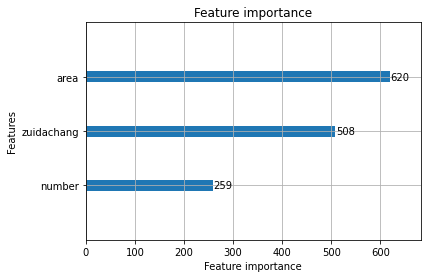

In [13]:
from lightgbm import plot_importance
plot_importance(model_lgb.best_estimator_)

In [14]:
import os
#path="/media/mtc206/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp37/labels/"
#path="/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp37/labels/"
path="/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp56/labels/"
a=set()
for i in os.listdir(path):
    a.add(i[:-5])
#print(a)
import re
d=[]
for i in a:
    b=[]
    for j in os.listdir(path):
        c=[]
        if(j[-4:]!='.txt'):
            continue
        if(i==j[:-5]):
            txt_name = j[:-4] + ".txt"
            # save_path = r".\stamp_myhandle", save_stamp_info_path = r"stamp_info_txt"
            txt_path = os.path.join(path, txt_name)
            with open(txt_path, "r", encoding='gbk') as fr:
                for line in fr.readlines():
                    line = line.strip()
                    line_list = line.split(" ")
                    xml_w = float(line_list[-2])
                    xml_h = float(line_list[-1])
                    xml_length=max(xml_w,xml_h)
                    xml_area=xml_w*xml_h
                    c=[xml_length,xml_area]
                    b.append(c)
    d.append(b)
zip(list(a),d)

k={}
for i in range(a.__len__()):
    k[list(a)[i]]=d[i]
for i in os.listdir("/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp56/"):
    if i[-3:]!='jpg':
        
        #print(2)
        continue
    if i[:-5] not in list(k.keys()):
        k.update({i[:-5]:[]})
        #print(1)
list_length=[]
list_area=[]
list_number=[]
for i in k:
    max_length=0
    area=0
    n=0
    for j in k[i]:
        max_length=max(max_length,j[0])
        area+=j[1]
        n+=1
    list_length.append(max_length)
    list_area.append(area)
    list_number.append(n)
    
df=pd.DataFrame()
df['名称']=list(k.keys())
df['最大长']=list_length
df['面积']=list_area
df['个数']=list_number


In [15]:
df

,名称,最大长,面积,个数
0,26_2013-17.4-1,0.792204,0.539684,11
1,18_2013-14.6-6,0.334619,0.020999,3
2,2348_纪93.2-1.4,0.459054,0.093775,6
3,93_2013-特8,0.325859,0.047608,4
4,2338_纪8.3-1,0.841040,1.786658,18
5,2339_纪8.3-1.1,0.883204,1.757982,17
6,2335_纪7东.2-1,0.793736,0.682127,15
7,2337_纪7东.2-1.2,0.774265,1.438439,16
8,63_2013-30.4-1,0.287879,0.032804,4
9,58_2013-2.3-3,0.451532,0.462728,13


In [43]:
df

,名称,最大长,面积,个数
0,纪93.2-1.4,0.459054,0.093775,6
1,2013-30.4-1,0.287879,0.032804,4
2,纪8.3-1.1,0.883204,1.757982,17
3,2013-20.2-2,0.240789,0.024455,4
4,纪7东.2-1,0.793736,0.682127,15
5,纪93.2-1.3,0.453668,0.143751,8
6,2013-2.3-3,0.451532,0.462728,13
7,2013-17.4-1,0.792204,0.539684,11
8,2014-13.4-3,0.325792,0.148600,33
9,纪7东.2-1.2,0.774265,1.438439,16


In [24]:
#模型训练
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import math
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error ,accuracy_score

numerical_cols =ans.select_dtypes(exclude = 'object').columns

ans['chikong']=ans['chikong'].astype(float)
#train=ans[:int(0.9*len(ans))]
train=ans
test=ans[int(0.9*len(ans)):]
feature_cols = [col for col in numerical_cols if col not in ['label']]
feature_cols = [col for col in feature_cols if 'chikong' not in col]
#feature_cols = [col for col in feature_cols if 'area' not in col]

## 提前特征列，标签列构造训练样本和测试样本
X_data = train[feature_cols]
Y_data = train['chikong']
X_test  = test[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)


X train shape: (19, 3)
X test shape: (2, 3)


In [25]:
x_val,y_val = X_data,Y_data

In [26]:
x_val

,zuidachang,area,number
0,0.792204,0.539684,11
1,0.334619,0.020999,3
2,0.459054,0.093775,6
3,0.325859,0.047608,4
4,0.841040,1.786658,18
5,0.883204,1.757982,17
6,0.793736,0.682127,15
7,0.774265,1.438439,16
8,0.287879,0.032804,4
9,0.451532,0.462728,13


In [27]:
val_lgb_c = model_lgb.predict(x_val)

In [28]:
val_lgb_c

array([          2,           1,           2,           1,           2,           2,           2,           2,           1,           2,           1,           2,           1,           1,           1,           1,           2,           1,           2])

In [30]:
#val_lgb_c = model_lgb.predict(x_val)
#val_lgb=[min(max(0,i),3) for i in val_lgb]
#val_lgb=[round(i) for i in val_lgb]
#MAE_lgb_c = accuracy_score(y_val,val_lgb_c)
#print('MAE of val with lgb:',MAE_lgb_c)
val_lgb = model_lgb1.predict(x_val)
val_lgb=[min(max(0,i),3) for i in val_lgb]
val_lgb=[round(i) for i in val_lgb]
MAE_lgb = accuracy_score(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)
y_test = clf.predict(x_val)
count = sum(y_val == y_test)
print(count, count/len(y_test))
l=(val_lgb_c+val_lgb+np.array(y_val))/3
for i in range(l.__len__()):
    l[i]=round(l[i])
    
    
print('final acc:',sum((l== y_val))/len(y_test))

MAE of val with lgb: 0.7368421052631579
14 0.7368421052631579
final acc: 0.7368421052631579


In [50]:
path="/2TB/wjn/yolov5/beifen/yolov5/runs/detect/exp56/labels/"

In [63]:
s1=set()
def think0(l):
    for j in os.listdir("/2TB/wjn/yolov5/beifen/yolov5/挑出来的/test2"):
        s1.add(j.split('_')[1][:-5])
        if j.split('_')[1][:-5] ==l:
            return True
        
    return False

df['名称'].apply(think0)

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
Name: 名称, dtype: bool

In [61]:
 for i in list(s1):
        if i  in df['名称']:
            print(i)

In [64]:
s1

{'2013-14.6-5',
 '2013-14.6-6',
 '2013-17.4-1',
 '2013-17.4-2',
 '2013-17.4-4',
 '2013-2.3-3',
 '2013-20.2-2',
 '2013-30.4-1',
 '2013-特8',
 '2014-13.4-3',
 '特51.3-1',
 '纪7东.2-1',
 '纪7东.2-1.1',
 '纪7东.2-1.2',
 '纪8.3-1',
 '纪8.3-1.1',
 '纪93.2-1.1',
 '纪93.2-1.3',
 '纪93.2-1.4'}